In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# EDA

In [2]:
data = pd.read_csv("./diabetes.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 每个特征的分布

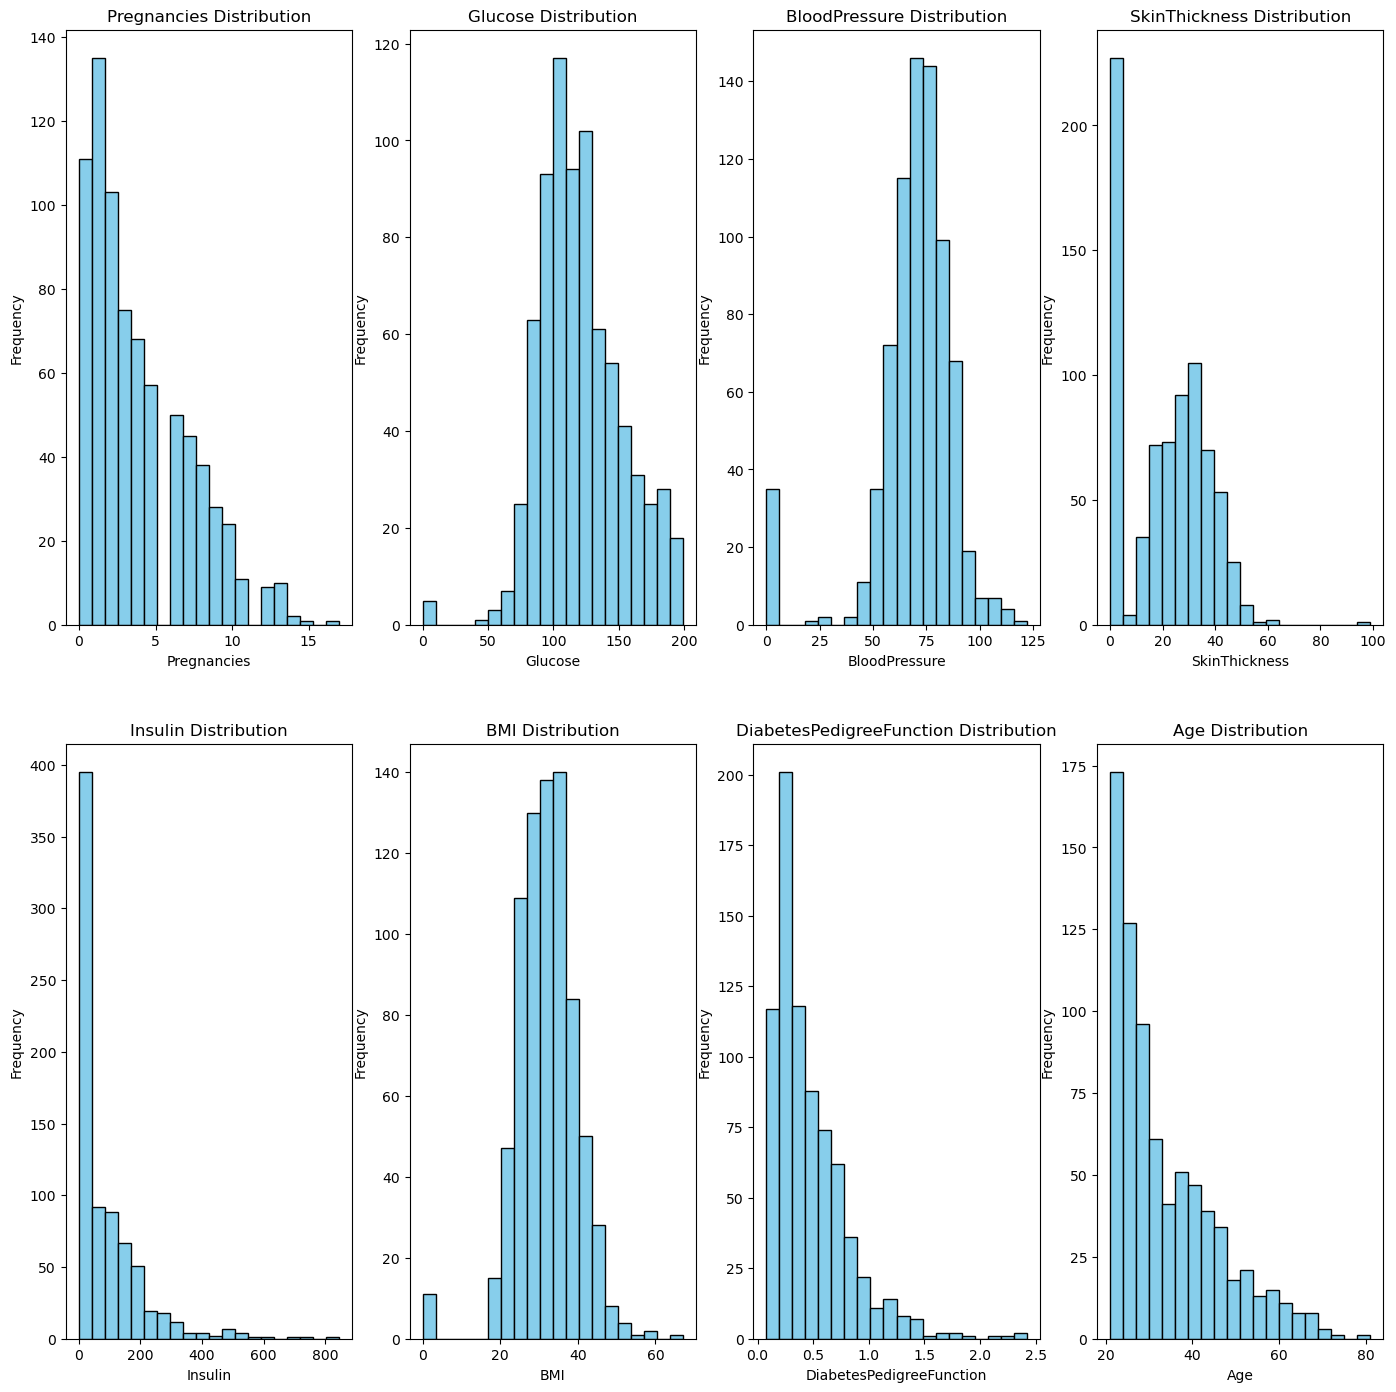

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(17, 17))

# 对每个特征进行直方图可视化
for i, column in enumerate(data.columns[:-1]):
    ax = axes[i//4, i%4]
    ax.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'{column} Distribution')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

- Pregnancies，Insulin，DiabetepedigreeFunction, Age 呈现右偏
- Pregnancies、Insulin、DiabetesPedigreeFunction 的正常值通常较小，呈现右偏的特征；
- 而 Age 的右偏可能导致数据不均衡，特别是在处理与糖尿病相关的预测问题时。
- 右偏分布会导致某些数据点对模型产生不平衡的影响，进而影响模型的训练和预测效果。

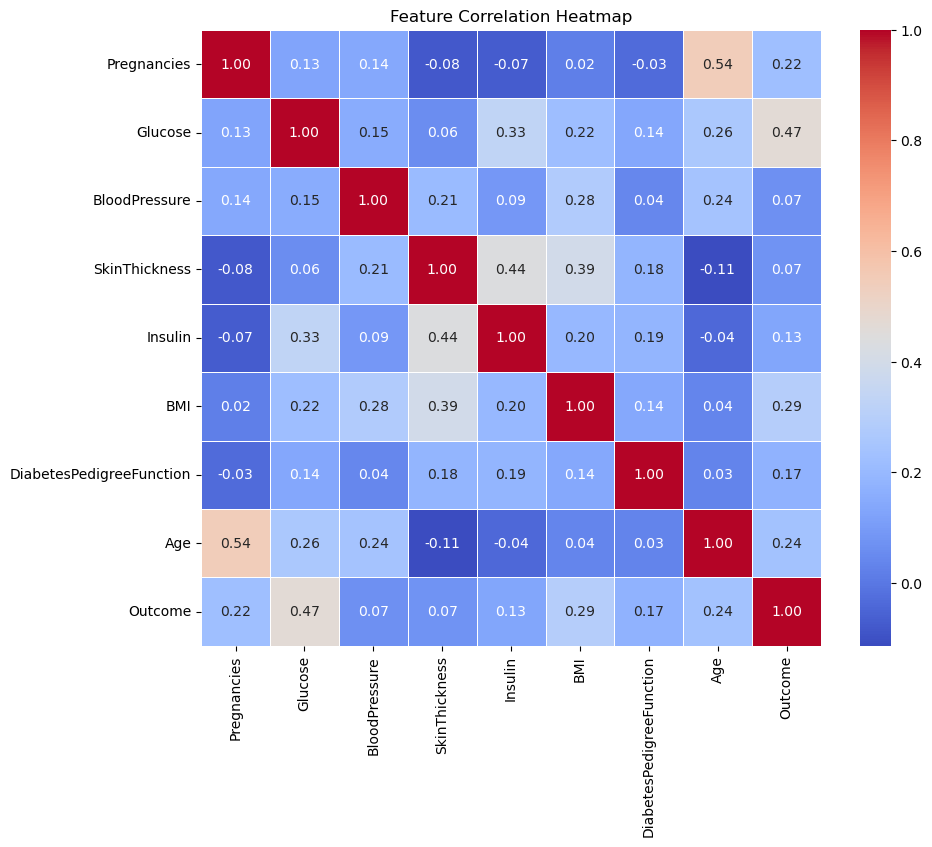

In [5]:
correlation_matrix = data.corr()

# 使用热力图显示相关性矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

Gluson(血糖) 和 结果（糖尿病）有很强的相关性，其次是 BMI 和 age，这也都符合我们的一般认识

## 可视化目标变量

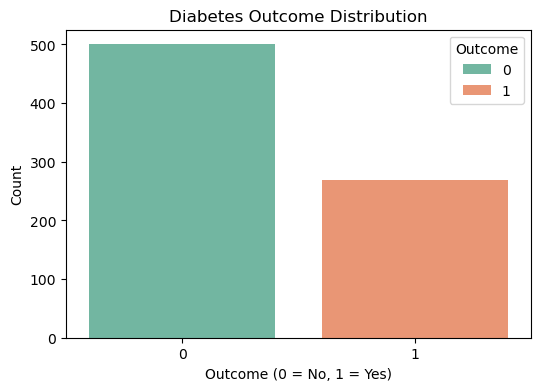

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=data, palette='Set2',hue='Outcome')
plt.title('Diabetes Outcome Distribution')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# 变量选择

In [7]:
# 移除相关性低的变量
data.drop(columns=['BloodPressure', 'SkinThickness', 'Insulin'], inplace=True)

# 训练 KNN

In [8]:
X = data.drop(columns=['Outcome']) 
y = data['Outcome']

## 欠采样

In [9]:
from imblearn.under_sampling import RandomUnderSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 因为数据不均衡，所以要进行欠采样。
under_sampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

## 训练

In [13]:
# KNN模型
knn = KNeighborsClassifier()

# 定义参数搜索范围
param_grid = {
    'n_neighbors': np.arange(1, 100),  # 邻居个数从1到20
    'p': [1, 2]  # 1是曼哈顿距离，2是欧几里得距离
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳成绩
print("欠采样前最佳参数组合:", grid_search.best_params_)
print("欠采样前最佳交叉验证得分:", grid_search.best_score_)

# 使用最佳参数训练并预测
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"欠采样前测试集准确率: {accuracy:.2f}")

# 输出分类报告
print("欠采样前分类报告:")
print(classification_report(y_test, y_pred))


# --- 欠采样后模型训练 ---
print("\n欠采样后模型训练：")
# KNN模型
grid_search.fit(X_train_resampled, y_train_resampled)

# 输出最佳参数和最佳成绩
print("欠采样后最佳参数组合:", grid_search.best_params_)
print("欠采样后最佳交叉验证得分:", grid_search.best_score_)

# 使用最佳参数训练并预测
best_knn = grid_search.best_estimator_
y_pred_resampled = best_knn.predict(X_test)

# 评估模型
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)
print(f"欠采样后测试集准确率: {accuracy_resampled:.2f}")

# 输出分类报告
print("欠采样后分类报告:")
print(classification_report(y_test, y_pred_resampled))

# --- 比较结果 ---
print("\n模型性能比较:")
print(f"欠采样前准确率: {accuracy:.2f}")
print(f"欠采样后准确率: {accuracy_resampled:.2f}")

欠采样前最佳参数组合: {'n_neighbors': 23, 'p': 1}
欠采样前最佳交叉验证得分: 0.7801679328268692
欠采样前测试集准确率: 0.74
欠采样前分类报告:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        99
           1       0.65      0.58      0.62        55

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154


欠采样后模型训练：
欠采样后最佳参数组合: {'n_neighbors': 10, 'p': 1}
欠采样后最佳交叉验证得分: 0.7699316005471957
欠采样后测试集准确率: 0.75
欠采样后分类报告:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        99
           1       0.62      0.76      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154


模型性能比较:
欠采样前准确率: 0.74
欠采样后准确率: 0.75


/opt/homebrew/Caskroom/miniconda/base/envs/GPTSoVits/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


- 通过对比欠采样前后的 KNN 模型结果，发现欠采样对模型有所改进。欠采样前，模型的准确率为 0.74，糖尿病类别（类别 1）的召回率较低（0.58）。
- 欠采样后，准确率提升至 0.75，糖尿病类别的召回率提高到 0.76，但精确率略微下降（从 0.65 降到 0.62）。
- 欠采样提高了对糖尿病的识别能力，但也使得对非糖尿病类别的精确率有所下降。总的来说，欠采样改善了少数类的识别，但需要平衡精确率和召回率。

## 可视化网格搜索结果

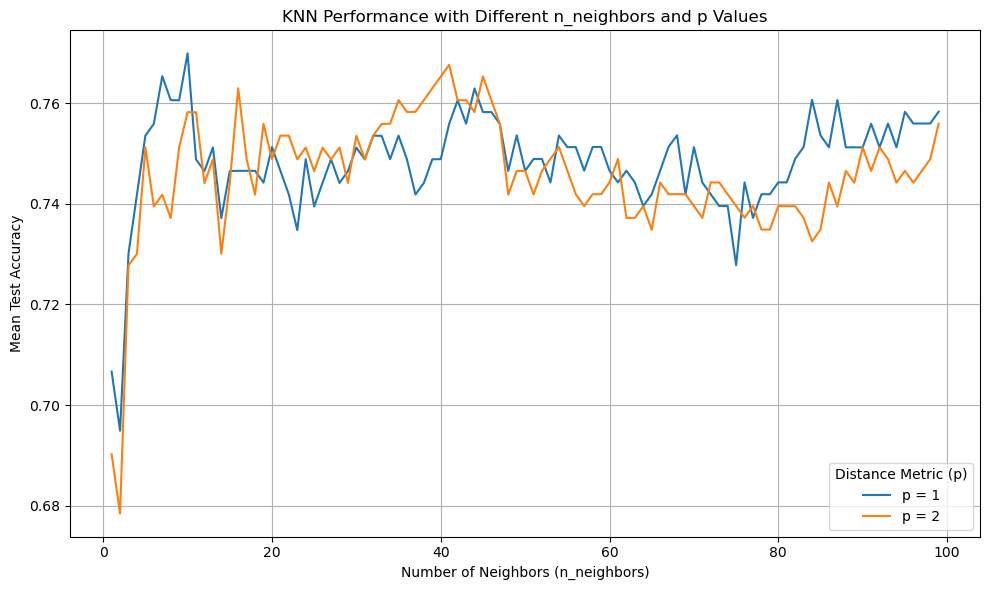

In [14]:
# 提取GridSearchCV结果
results = grid_search.cv_results_

# 绘制折线图 - n_neighbors与准确率
plt.figure(figsize=(10, 6))

# 绘制不同的 p 值下，n_neighbors（K值）与准确率的关系
for p_value in param_grid['p']:
    # 获取对应 p 值下的 mean_test_score
    scores = results['mean_test_score'][results['param_p'] == p_value]
    plt.plot(param_grid['n_neighbors'], scores, label=f'p = {p_value}')

plt.title('KNN Performance with Different n_neighbors and p Values')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Test Accuracy')
plt.legend(title="Distance Metric (p)", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 其他模型（SVM）

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 定义 SVM 模型
svm = SVC(random_state=42)

# 设置超参数搜索范围
param_grid = {
    'C': [0.1, 1, 10, 100],           # 正则化参数
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # 核函数的参数
    'kernel': ['linear', 'rbf']       # 核函数类型
}

# 在欠采样前的训练数据上执行超参数搜索
grid_search_before = GridSearchCV(svm, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_before.fit(X_train, y_train)

# 输出欠采样前的最佳参数和模型表现
print(f"欠采样前最佳参数: {grid_search_before.best_params_}")

# 获取欠采样前的最佳模型并在测试集上做预测
best_svm_before = grid_search_before.best_estimator_
y_pred_before = best_svm_before.predict(X_test)

# 评估欠采样前的模型
accuracy_before = accuracy_score(y_test, y_pred_before)
print(f"欠采样前测试集准确率: {accuracy_before:.2f}")
print("\n欠采样前分类报告:")
print(classification_report(y_test, y_pred_before))

# 在欠采样后的训练数据上执行超参数搜索
grid_search_after = GridSearchCV(svm, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_after.fit(X_train_resampled, y_train_resampled)

# 输出欠采样后最佳参数和模型表现
print(f"欠采样后最佳参数: {grid_search_after.best_params_}")

# 获取欠采样后最佳模型并在测试集上做预测
best_svm_after = grid_search_after.best_estimator_
y_pred_after = best_svm_after.predict(X_test)

# 评估欠采样后模型
accuracy_after = accuracy_score(y_test, y_pred_after)
print(f"欠采样后测试集准确率: {accuracy_after:.2f}")
print("\n欠采样后分类报告:")
print(classification_report(y_test, y_pred_after))

# 比较欠采样前后的性能
print("\n模型性能比较:")
print(f"欠采样前准确率: {accuracy_before:.2f}")
print(f"欠采样后准确率: {accuracy_after:.2f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
欠采样前最佳参数: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
欠采样前测试集准确率: 0.76

欠采样前分类报告:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.69      0.60      0.64        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154

Fitting 5 folds for each of 40 candidates, totalling 200 fits
欠采样后最佳参数: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
欠采样后测试集准确率: 0.73

欠采样后分类报告:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        99
           1       0.58      0.82      0.68        55

    accuracy                           0.73       154
   macro avg       0.73      0.75      0.72       154
weighted avg       0.77      0.73      0.73       154


模型性能比较:
欠采样前准确率: 0.76
欠采样后准确率: 0.73


- 欠采样前后，SVM 模型的最佳参数选择一致，都是 {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}。
- 欠采样前，模型的准确率为 0.76，表现较好，尤其是在区分非糖尿病（类别0）时，召回率为 0.85，精确率为 0.79。
- 然而，在糖尿病的识别上，召回率较低，仅为 0.60，精确率为 0.69，表现较差。
- 欠采样后，虽然糖尿病的召回率提高到 0.82，但整体准确率下降至 0.73，同时非糖尿病的召回率下降至 0.68，精确率提高至 0.87，导致精确率和召回率之间的不平衡。
- 综上所述，欠采样改善了糖尿病类别的召回率，但也导致了非糖尿病类别的召回率下降，整体准确率有所下降。

## 模型比较

SVM 比 KNN 效果好，是因为 SVM 可以更好的拟合高维数据，并且 rbf 核可以更好的捕捉决策边界。